## 导包

In [5]:
import os
import matplotlib.pyplot as plt
# pycharm中删掉就行
%matplotlib inline 
import numpy as np
import torch
from torch import nn
import torch.optim as optim
import torchvision
#pip install torchvision    #如果你的电脑没有安装torchvision模块就得去用这个指令安装
from torchvision import transforms, models, datasets # transforms——数据增强。models——现成的模型。datasets——目录结构
#https://pytorch.org/docs/stable/torchvision/index.html  #模块的官方网址，上面例子有教你怎么用
import imageio
import time
import warnings
import random
import sys
import copy
import json
from PIL import Image

## 数据读取

In [6]:
data_dir = './flower_data/' # 数据所在目录
train_dir = data_dir + '/train' # 训练集
valid_dir = data_dir + '/valid' # 验证集

## 数据预处理

In [7]:
data_transforms = {
    'train': 
    transforms.Compose([ # 按顺序执行下面的操作
        transforms.Resize([96,96]),#统一图片大小【别选太大，慢而且可能算力不够】
        transforms.RandomRotation(45),#随机旋转，-45到45度之间随机选，太大了都倒着了不太合适
        transforms.CenterCrop(64),#在96×96的图片随机裁剪出64×64的。（随机裁剪得到的数据更多）
        transforms.RandomHorizontalFlip(p=0.5),#随机水平翻转 选择一个概率去翻转，0.5就是50%翻转，50%不翻转
        transforms.RandomVerticalFlip(p=0.5),#随机垂直翻转
        transforms.ColorJitter(brightness=0.2, contrast=0.1, saturation=0.1, hue=0.1),#参数1为亮度，参数2为对比度，参数3为饱和度，参数4为色相
        transforms.RandomGrayscale(p=0.025),#概率转换成灰度率，3通道就是R=G=B【这个和上面一个不常用】
        transforms.ToTensor(),  #数据转成tensor的格式
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])#均值，标准差（拿人家算好的）三个值对应RGB
    ]),
    'valid': # 实际应用效果以实际图像为准，不需要增强了，而且够用了，"考卷"多了也没必要
    transforms.Compose([
        transforms.Resize([64,64]), # 训练数据裁剪后最终是64的，这里直接resize到64
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) #要和训练集保持一致的标准化操作
    ]),
}
  ### 【一般训练集咋做，验证集就咋做】

## 数据加载

In [6]:
batch_size = 128

#datasets.ImageFolder 加载器 文件夹名作为文件夹下数据的标签
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'valid']}
# train的数据做train对应的预处理，valid同理。os.path.join(data_dir, x)<=>flower_data/train/
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True) for x in ['train', 'valid']}#数据加载
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']} # 训练集大小
class_names = image_datasets['train'].classes

### 读取标签的实际名字

In [7]:
with open('cat_to_name.json', 'r') as f: # json文件以字典存放文件夹编号和花卉名称的对应关系【用于最后名称展示】
    cat_to_name = json.load(f) 

## 模型配置

### 加载models中提供的模型，并且直接用训练的好权重当做初始化参数
- 第一次执行需要下载，可能会比较慢，我会提供给大家一份下载好的，可以直接放到相应路径

### 参数设置

In [8]:
# 模型
model_name = 'resnet18'  #可选的比较多 ['resnet', 'alexnet', 'vgg', 'squeezenet', 'densenet', 'inception']
# 可以举例演示查看
model_ft = models.resnet18() # 可以选18、50、101、152层等
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [9]:
# 是否用GPU训练
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


CUDA is available!  Training on GPU ...


In [10]:
# 训练哪些部分
feature_extract = True # 只训练输出层

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters(): # 遍历每个参数，设置反向传播时不计算梯度，不更新参数
            param.requires_grad = False 


### 初始化模型配置

In [14]:
# 初始化模型函数
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # 选择合适的模型，不同模型的初始化方法稍微有点区别
    model_ft = None
    input_size = 0

    if model_name == "resnet18":
        """ Resnet
        """
        
        # model_ft = models.model_name(pretrained=use_pretrained) # models.resnet18 模型。pretrained=use_pretrained 使用预训练好的参数
        # models.model_name【Python 会把 model_name 当成 models 模块的一个固定属性，而不是使用变量 model_name 的值】 
        # 改为 getattr(models, model_name)【根据字符串 model_name 的值（比如 "resnet18"），获取 models 模块中对应的属性（比如 models.resnet18】
        model_ft = getattr(models, model_name)(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract) # 是否冻结参数 【下面的自定义输出层没被冻上】
        num_ftrs = model_ft.fc.in_features # 查询全连接层（输出层）的输入大小
        model_ft.fc = nn.Sequential(nn.Linear(num_ftrs, num_classes), # 自定义输出层，保持输入大小，输出改为102【默认要反向传播更新参数】
                                   nn.LogSoftmax(dim=1))
        input_size = 64 # 配置高可以增加

#     elif model_name == "alexnet":
#         """ Alexnet
#         """
#         model_ft = models.alexnet(pretrained=use_pretrained)
#         set_parameter_requires_grad(model_ft, feature_extract)
#         num_ftrs = model_ft.classifier[6].in_features
#         model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
#         input_size = 224

#     elif model_name == "vgg":
#         """ VGG11_bn
#         """
#         model_ft = models.vgg16(pretrained=use_pretrained)
#         set_parameter_requires_grad(model_ft, feature_extract)
#         num_ftrs = model_ft.classifier[6].in_features
#         model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
#         input_size = 224

#     elif model_name == "squeezenet":
#         """ Squeezenet
#         """
#         model_ft = models.squeezenet1_0(pretrained=use_pretrained)
#         set_parameter_requires_grad(model_ft, feature_extract)
#         model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
#         model_ft.num_classes = num_classes
#         input_size = 224

#     elif model_name == "densenet":
#         """ Densenet
#         """
#         model_ft = models.densenet121(pretrained=use_pretrained)
#         set_parameter_requires_grad(model_ft, feature_extract)
#         num_ftrs = model_ft.classifier.in_features
#         model_ft.classifier = nn.Linear(num_ftrs, num_classes)
#         input_size = 224

#     elif model_name == "inception":
#         """ Inception v3
#         Be careful, expects (299,299) sized images and has auxiliary output
#         """
#         model_ft = models.inception_v3(pretrained=use_pretrained)
#         set_parameter_requires_grad(model_ft, feature_extract)
#         # Handle the auxilary net
#         num_ftrs = model_ft.AuxLogits.fc.in_features
#         model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
#         # Handle the primary net
#         num_ftrs = model_ft.fc.in_features
#         model_ft.fc = nn.Linear(num_ftrs,num_classes)
#         input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size


### 参数更新配置

In [17]:
# 初始化模型
model_ft, input_size = initialize_model(model_name, 102, feature_extract, use_pretrained=True) #改成我们要训练的102类

#GPU计算
model_ft = model_ft.to(device)

# 最佳模型保存（网络结构+参数）
filename='best.pt'

# 存储并打印要训练哪些参数
params_to_update = model_ft.parameters() # params_to_update 列表 存储要更新的参数
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else: # else对应的逻辑是 不改变 params_to_update 列表 直接存储model_ft.parameters()
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\dy/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100.0%


Params to learn:
	 fc.0.weight
	 fc.0.bias


### 优化器

In [23]:
# 优化器设置，常用optim.Adam
optimizer_ft = optim.Adam(params_to_update, lr=1e-2) # 放入要更新的参数 ，学习率=0.01
# 衰减器
scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)#学习率每7个epoch衰减成原来的1/10
#最后一层已经LogSoftmax()了，所以不能nn.CrossEntropyLoss()来计算了，nn.CrossEntropyLoss()相当于logSoftmax()和nn.NLLLoss()整合
criterion = nn.NLLLoss() # 损失函数

### 训练配置

In [24]:
# 模型、数据、损失、优化器、迭代次数（默认25）、参数保存路径
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False,filename=filename): 
    since = time.time() # 记录当前时间
    best_acc = 0 # 记录最好的一次准确率
    """
    checkpoint = torch.load(filename)
    best_acc = checkpoint['best_acc']
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    model.class_to_idx = checkpoint['mapping']
    """
    model.to(device)   #用GPU或CPU训练
    
    # 记录每次epoch的准确率和损失
    val_acc_history = []
    train_acc_history = []
    train_losses = []
    valid_losses = []
    # 获取学习率，在优化器字典对象里找
    LRs = [optimizer.param_groups[0]['lr']]
    # 把当前的参数记录下来作为初始值，后续有更好的再更新
    best_model_wts = copy.deepcopy(model.state_dict())
    
    # 一个epoch-1个epoch来遍历【1个epoch对应多次迭代】——————————
    for epoch in range(num_epochs):
        # 打印当前执行到第几个epoch
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # 训练和验证【一次epoch包括训练和验证阶段】——————————
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # 训练
            else:
                model.eval()   # 验证
            
            # 初始化损失和正确个数
            running_loss = 0.0
            running_corrects = 0

            # 把数据都取个遍【iter 迭代】————————————
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)   #将input传入GPU计算
                labels = labels.to(device)   #将labels传入GPU计算

                # 先清零再更新【梯度计算会累加上一次的epoch，不会自动清零】
                optimizer.zero_grad()
                # 只有训练的时候计算和更新梯度
                with torch.set_grad_enabled(phase == 'train'):
                    if is_inception and phase == 'train':
                        outputs, aux_outputs = model(inputs) # 输出
                        loss1 = criterion(outputs, labels) # 计算损失
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:#resnet执行的是这里
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1) # 拿到最大的输出作为预测值

                    # 只有训练阶段更新权重【训练和验证都前向传播，只有训练需要再反向传播】
                    if phase == 'train':
                        loss.backward()# 反向传播
                        optimizer.step()# 参数更新

                # 累加每次迭代的损失和正确个数
                running_loss += loss.item() * inputs.size(0) # inputs.size(0) 表示 batch
                running_corrects += torch.sum(preds == labels.data) # 统计正确个数
            
            # ————————  一次epoch的所有迭代结束 ————————————
            
            # 计算这次epoch损失和准确率
            epoch_loss = running_loss / len(dataloaders[phase].dataset) # 总损失/总数据量
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset) # 总正确个数/总数据量
            
            # 打印这次epoch的训练信息
            time_elapsed = time.time() - since # 耗费时间
            print('Time elapsed {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc)) # 损失、准确率
            

            # 得到最好那次的模型
            if phase == 'valid' and epoch_acc > best_acc: # 更强——验证准确率更高
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict()) # 记录当前（最好）的参数
                state = {
                  'state_dict': model.state_dict(), # 参数字典 key就是各层的名字，值就是训练好的权重
                  'best_acc': best_acc, # 准确率
                  'optimizer' : optimizer.state_dict(), # 优化器参数
                }
                torch.save(state, filename) # 保存到本地文件
                
            # 保存每次epoch的损失和准确率的历史记录
            if phase == 'valid':
                val_acc_history.append(epoch_acc)
                valid_losses.append(epoch_loss)
            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_losses.append(epoch_loss)
        
        # ———————— 一次epoch即将结束，真正结束前再调整一下学习率 ——————————
        
        print('Optimizer learning rate : {:.7f}'.format(optimizer.param_groups[0]['lr'])) # 打印当前学习率
        LRs.append(optimizer.param_groups[0]['lr'])# 保存当前学习率
        print()
        scheduler.step()# 执行学习率衰减器（每n次epoch衰减一次）
    
    
    # —————————————— 所有epoch结束，训练完成 ————————————————
    
    time_elapsed = time.time() - since # 训练耗费总时间
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc)) # 最佳准确率

    # 训练完后 用最好的一次当做模型最终的结果
    model.load_state_dict(best_model_wts) # 加载记录好的最佳参数
    return model, val_acc_history, train_acc_history, valid_losses, train_losses, LRs # 返回 最佳模型、历史损失和正确率、学习率


## 开始训练

- 只训练输出层

In [25]:
model_ft,val_acc_history, train_acc_history, valid_losses, train_losses, LRs = train_model( # 调用训练函数模块
model_ft, # 模型
dataloaders, # 加载器
criterion, # 损失
optimizer_ft, # 优化器
num_epochs=20, # 次数
is_inception=(model_name=="inception")) 

Epoch 0/19
----------
Time elapsed 0m 35s
train Loss: 3.1440 Acc: 0.4731
Time elapsed 0m 38s
valid Loss: 4.9143 Acc: 0.3337
Optimizer learning rate : 0.0100000

Epoch 1/19
----------
Time elapsed 1m 13s
train Loss: 2.9106 Acc: 0.4911
Time elapsed 1m 15s
valid Loss: 4.7926 Acc: 0.3411
Optimizer learning rate : 0.0100000

Epoch 2/19
----------
Time elapsed 1m 50s
train Loss: 3.0020 Acc: 0.4954
Time elapsed 1m 53s
valid Loss: 4.7580 Acc: 0.3289
Optimizer learning rate : 0.0100000

Epoch 3/19
----------
Time elapsed 2m 26s
train Loss: 2.8316 Acc: 0.4982
Time elapsed 2m 30s
valid Loss: 4.8566 Acc: 0.3313
Optimizer learning rate : 0.0100000

Epoch 4/19
----------
Time elapsed 3m 5s
train Loss: 2.9893 Acc: 0.4916
Time elapsed 3m 8s
valid Loss: 4.5769 Acc: 0.3350
Optimizer learning rate : 0.0100000

Epoch 5/19
----------
Time elapsed 3m 43s
train Loss: 2.9859 Acc: 0.4916
Time elapsed 3m 46s
valid Loss: 5.0297 Acc: 0.3215
Optimizer learning rate : 0.0100000

Epoch 6/19
----------
Time elapsed 4

- 训练所有层【fc输出层已经训练得还不错了，这时就可以解冻前面的模型了，一起训练】

### 修改参数更新配置及优化器

In [26]:
# 将所有参数解冻
for param in model_ft.parameters():
    param.requires_grad = True  

# 优化器需要更新所有参数，学习率调小一点
optimizer_ft = optim.Adam(model_ft.parameters(), lr=1e-3)  
scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)  

# 损失函数
# criterion = nn.NLLLoss()  # 注意：由于你使用了 LogSoftmax，应该继续使用 NLLLoss

In [27]:
# Load the checkpoint 加载之前训练好的模型【进程结束后，内存就没有训练好的模型了】

checkpoint = torch.load(filename) # 从文件获取模型
best_acc = checkpoint['best_acc'] # 将之前的最佳准确率作为初始值
#【bug吧，因为训练函数一进去就会把它初始化为0，也就是说第一次epoch后才会记录，漏掉了第0次也就是初始模型万一就是最佳的情况。不过这个无所谓】
model_ft.load_state_dict(checkpoint['state_dict']) # 加载模型
# optimizer.load_state_dict(checkpoint['optimizer'])
# model_ft.class_to_idx = checkpoint['mapping']

<All keys matched successfully>

### 开始训练所有层

In [28]:
# 开始训练
model_ft,val_acc_history, train_acc_history, valid_losses, train_losses, LRs = train_model(
model_ft,
dataloaders,
criterion,
optimizer_ft,
num_epochs=20, 
is_inception=(model_name=="inception"))

Epoch 0/19
----------
Time elapsed 0m 46s
train Loss: 3.4116 Acc: 0.3738
Time elapsed 0m 50s
valid Loss: 3.4064 Acc: 0.3399
Optimizer learning rate : 0.0010000

Epoch 1/19
----------
Time elapsed 1m 34s
train Loss: 1.7469 Acc: 0.5647
Time elapsed 1m 38s
valid Loss: 2.3192 Acc: 0.4719
Optimizer learning rate : 0.0010000

Epoch 2/19
----------
Time elapsed 2m 21s
train Loss: 1.5434 Acc: 0.6116
Time elapsed 2m 25s
valid Loss: 4.0168 Acc: 0.4535
Optimizer learning rate : 0.0010000

Epoch 3/19
----------
Time elapsed 3m 6s
train Loss: 1.1996 Acc: 0.6888
Time elapsed 3m 9s
valid Loss: 2.1506 Acc: 0.4768
Optimizer learning rate : 0.0010000

Epoch 4/19
----------
Time elapsed 3m 47s
train Loss: 1.0538 Acc: 0.7125
Time elapsed 3m 50s
valid Loss: 2.5197 Acc: 0.4890
Optimizer learning rate : 0.0010000

Epoch 5/19
----------
Time elapsed 4m 29s
train Loss: 0.7998 Acc: 0.7698
Time elapsed 4m 33s
valid Loss: 1.8043 Acc: 0.5782
Optimizer learning rate : 0.0010000

Epoch 6/19
----------
Time elapsed 5

## 测试

### 加载训练好的模型

In [1]:
model_ft, input_size = initialize_model(model_name, 102, feature_extract, use_pretrained=True)

# GPU模式
model_ft = model_ft.to(device)

# 保存文件的名字
filename='best.pt'

# 加载模型
checkpoint = torch.load(filename)
best_acc = checkpoint['best_acc'] # 有bug，第二次训练的代码也有这个
#【bug吧，因为训练函数一进去就会把它初始化为0，也就是说第一次epoch后才会记录，漏掉了第0次也就是初始模型万一就是最佳的情况。不过这个无所谓】
model_ft.load_state_dict(checkpoint['state_dict'])


NameError: name 'initialize_model' is not defined

### 测试数据处理
（这里就用验证集来测试，不单独搞测试集了）

In [52]:
# 迭代器，一次获取一个batch的测试数据，next获取下一个【下次运行就是下一批数据了】
dataiter = iter(dataloaders['valid'])
images, labels = dataiter.__next__()  # 获取图像+标签 【Pytorch版本更新：next改为__next__】

# 验证模式，不做更新
model_ft.eval()

# 数据传入cuda还是直接传
if train_on_gpu:
    output = model_ft(images.cuda())
else:
    output = model_ft(images)

In [53]:
output.shape # torch.Size([128，102])。output表示对一个batch中每一个数据得到其属于各个类别的可能性

torch.Size([128, 102])

### 得到概率最大的类别

In [54]:
_, preds_tensor = torch.max(output, 1) # 得到概率最大的类别
# 用gpu还得先取到cpu再将tensor转成数组adarray形式【画图matplotlib只支持数组】【torch对应tensor对应gpu，numpy对应cpu】
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy()) 
preds # 一个批次的预测结果

array([ 18,  74,  42,  16,  90,  79,  36,  85,  19,  73,  64,  66,  98,
        90,  52,   9,  81,  43,  53,  73,  82,  62,  57,  16,  48,  50,
        49, 101,  27,  56,  90,  73,  24,  75,  85,  30,  52,  49,  98,
        70,  54,  17,  49,  56,   4,  14,  56,  20,   5,  11,  64,  11,
        49,  26,  49,  63,  65,  49,  74,  63,  53,   2,  23,  75,  64,
        75,  73,  49,  25,  52,  14,  99,  59,  81,  73, 100,  84,  74,
        29,  82,  82,  38,  15,  85,  24,  80,  55,  64,  55,  67,  77,
        60,  49,  25,  33,  49,  78,  19,  80,  59,  49,  70,  14,  43,
        61,  92,  15,  54,  78,  33,  82,  82,  74,  66,  13,  76,  83,
        51,  82,  85,  99,  74,  33,  28,  89,  17,  11,   6], dtype=int64)

### 预测结果展示

In [55]:
# 图像数据转换成原格式
def im_convert(tensor):
    """展示数据"""
    # 利用torch的dataloader取得，tensor结构，需要转到cpu转换成数组格式
    image = tensor.to("cpu").clone().detach() 
    image = image.numpy().squeeze() # squeeze()压缩

    image = image.transpose(1, 2, 0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1) # 防止数值越界或异常
    return image

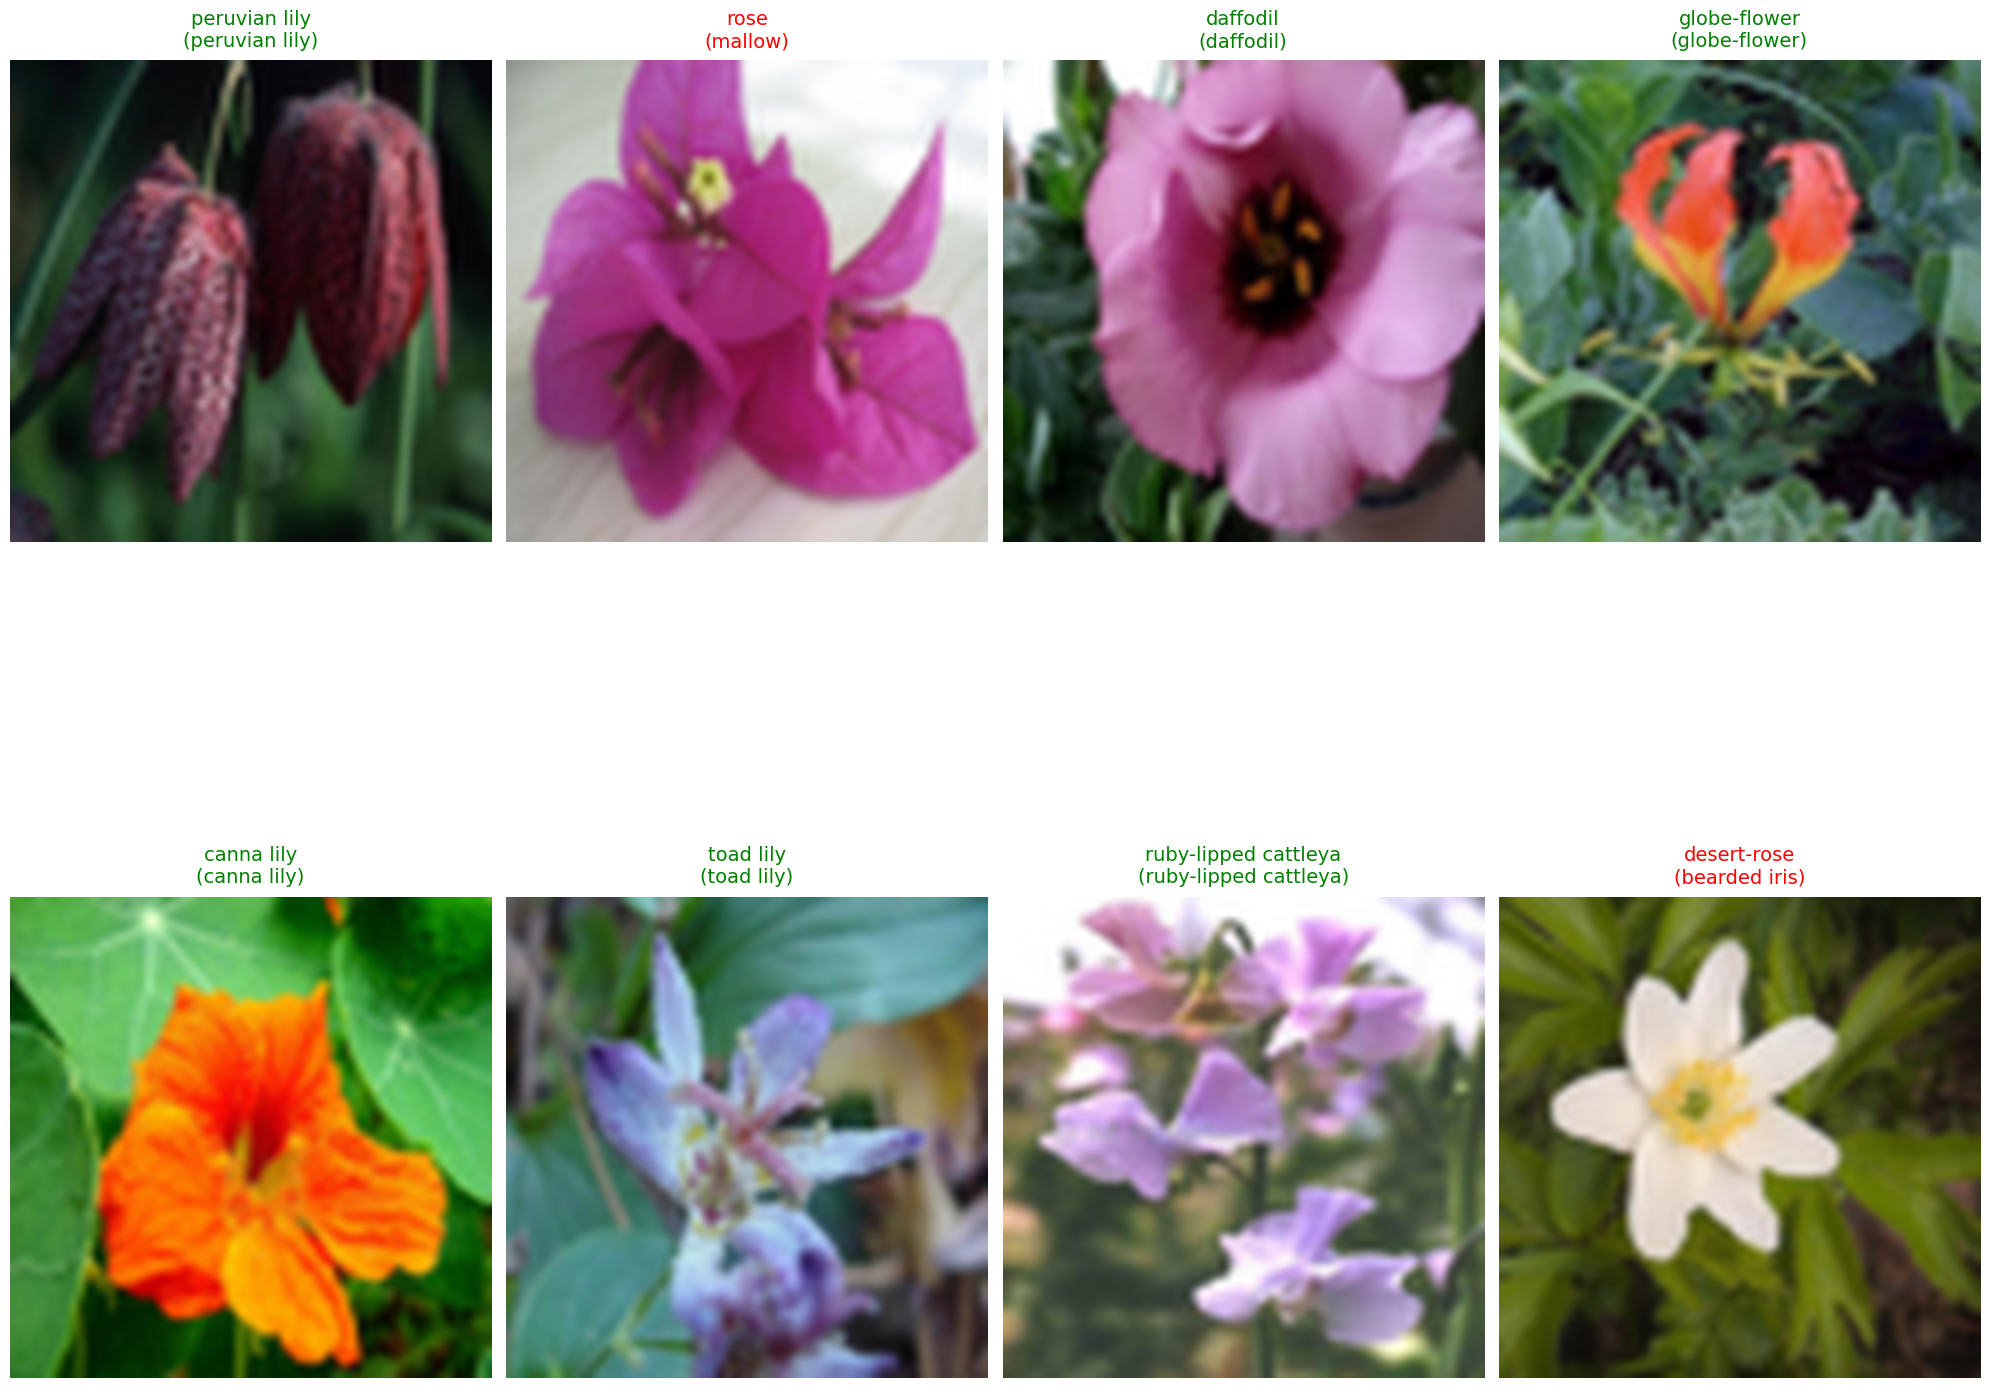

In [66]:
fig=plt.figure(figsize=(20, 20)) 
columns =4
rows = 2

# for idx in range (columns*rows): # 展示4×2个图像
#     ax = fig.add_subplot(rows, columns, idx+1, xticks=[], yticks=[])
#     plt.imshow(im_convert(images[idx]))
#     # 利用json得到数字对应的花卉名称。预测正确绿色，错误为红色 格式：预测(实际)
#     ax.set_title("{} ({})".format(cat_to_name[str(preds[idx])], cat_to_name[str(labels[idx].item())]), 
#                  color=("green" if cat_to_name[str(preds[idx])]==cat_to_name[str(labels[idx].item())] else "red"))
# plt.show() # 开始展示

for idx in range(columns * rows):
    ax = fig.add_subplot(rows, columns, idx + 1)
    ax.axis('off')  # 去掉坐标轴
    
    # 显示图像
    img = im_convert(images[idx])
    ax.imshow(img, interpolation='lanczos')  # 使用高质量插值
    
    # 获取预测和真实标签
    pred_label = cat_to_name.get(str(preds[idx]), f'未知{preds[idx]}')
    true_label = cat_to_name.get(str(labels[idx].item()), f'未知{labels[idx].item()}')
    
    # 判断是否正确
    is_correct = (preds[idx] == labels[idx].item())
    color = "green" if is_correct else "red"
    
    # 设置标题
    ax.set_title(f"{pred_label}\n({true_label})", 
                 color=color, 
                 fontsize=14, 
                 pad=10)

plt.tight_layout()
plt.show()


## 说明总结

将代码分为这几个部分：函数等配置，训练1，训练2，测试。。怎么运行代码实现功能？
- 首次执行所有代码：配置，训练1，训练2，测试
- 再训练：训练2
- 再测试：测试
- 重启内核后再训练：配置，训练2
- 重启内核后再测试：配置，测试